In [176]:
%matplotlib inline
from ggplot import *
import matplotlib as mpl
mpl.style.use('ggplot')
import pandas as pd
import numpy as np

This is an exploratory run for high-throughput analysis of tRNA identity elements. 

# GtRNAdb fungi species

We'll start from the GtRNAdb genome table dump to isolate fungi.

In [177]:
%%bash
grep "Fungi" /projects/lowelab/users/blin/tRNAscan/models/taxonomy/genome_table_20151017.txt > gtrnadb-fungi.txt

# Isolate fungal tRNAs

To do that, we'll dig through the tRNAscan runs. I picked leucine since it is well studied. The canonical _S. cerevesiae_ identity elements are A35, G37, and A73.

In [178]:
def copy_tRNAs():
  import subprocess
  for line in open('gtrnadb-fungi.txt'):
    tabs = line.strip().split('\t')
    src_file_name = '/projects/lowelab/users/pchan/GtRNAdb2/tRNA-runs/Eukaryota/' + tabs[0] + '/' + tabs[1] + '-tRNAs.fa'
    dest_file_name = './genomes/' + tabs[1] + '-tRNAs.fa'
    subprocess.call('cp {} {}'.format(src_file_name, dest_file_name), shell = True)

copy_tRNAs()

def isolate_leucine_tRNAs():
  from Bio import SeqIO
  leucine_tRNA_fhandle = open('fungi-Leu-tRNAs.fa', 'w')
  for line in open('gtrnadb-fungi.txt'):
    tabs = line.strip().split('\t')
    file_name = './genomes/' + tabs[1] + '-tRNAs.fa'
    for seq in SeqIO.parse(file_name, "fasta"):
      if "Leu" in seq.name:
        SeqIO.write(seq, leucine_tRNA_fhandle, 'fasta')

isolate_leucine_tRNAs()


# Filter and align leucine tRNAs

The next two steps involve Infernal. 

We use _cmsearch_ to filter out low-scoring leucines. This filters out tRNAs that we aren't completely confident are leucines, based on the eukaryotic leucine model.

Then, we use _cmalign_ to align tRNAs by secondary structure. This is to line up each tRNA at the proper position regardless of insertions, deletions, mismatches, or secondary structure mutations. In other words, it gets us the proper numbering.

In [182]:
def filter_align_Leu_tRNAs():
  import subprocess
  from Bio import SeqIO
  # filter out tRNAs that are clearly not cytosolic leucines (using the eukaryotic model)
  # we can afford to be stringent with this, so set to 50 bit cutoff
  subprocess.call('cmsearch -g --notrunc --toponly -T 50 --tblout fungi-Leu-tRNAs.out /projects/lowelab/users/blin/tRNAscan/models/current/TRNAinf-euk-Leu.cm fungi-Leu-tRNAs.fa', shell = True)
  leucine_tRNAs = []
  for line in open('fungi-Leu-tRNAs.out'):
    if line[0] == '#': continue
    leucine_tRNAs.append(line.split()[0])
  filtered_Leu_fhandle = open('fungi-Leu-tRNAs-filtered.fa', 'w')
  for seq in SeqIO.parse('fungi-Leu-tRNAs.fa', 'fasta'):
    if seq.name in leucine_tRNAs: SeqIO.write(seq, filtered_Leu_fhandle, 'fasta')
  filtered_Leu_fhandle.close()

  # we use --matchonly to make parsing easier. But it's possible that there's a conserved insertion within a clade. Oh well. 
  subprocess.call('cmalign -g --notrunc --matchonly -o fungi-Leu-tRNAs.sto /projects/lowelab/users/blin/tRNAscan/models/current/TRNAinf-euk-Leu.cm fungi-Leu-tRNAs-filtered.fa', shell = True)

filter_align_Leu_tRNAs()

# Parse alignment

Now, we loop through the tRNAs and identify nucleotides at key identity element positions. The goal is to build a table containing organism, tRNA, and N=3 columns for the number of identity elements. This requires parsing an alignment `.sto` file. At this point, we also filter out mitochondrial tRNAs.

We use A35, G37, and A73, reviewed in Giegé et al. (1998). 

In [184]:
def parse_alignment():
  import re
  identities_fhandle = open('fungi-Leu-identities.tsv', 'w')
  alignment_fhandle = open('fungi-Leu-tRNAs.sto')
  trnas = []
  for line in alignment_fhandle:
    if line[0] in ['#', '\n']:
      if line[0:12] != '#=GC SS_cons':
        continue
      else:
        break
    if "chrM" in line: continue
    trna = trna_identities()
    trna.name, trna.seq = line.strip().split()
    trna.organism = trna.name.split('tRNA')[0][:-1] # cut off tRNA and the underscore before it
    trna.anticodon = trna.name.split('tRNA-Leu-')[1][0:3]
    trnas.append(trna)
  
  # parse consensus secondary structure
  seq = line.strip().split()[2]
  # need the new position of A35 and G37. to get to the right position, we need to find the 2nd loop. the anticodon itself is standard.
  match_obj = re.finditer('_+', seq)
  # discard first loop (d loop)
  _ = match_obj.__next__()
  A35_position = match_obj.__next__().span()[0] + 3
  G37_position = A35_position + 2
  # A73 should just be the last position
  A73_position = len(seq) - 1 # subtract one since we are pulling out of a string and we need the right index

  for trna in trnas:
    identities_fhandle.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(trna.organism, trna.name, trna.anticodon, trna.seq[A35_position], trna.seq[G37_position], trna.seq[A73_position]))
  

class trna_identities:
  def __init__(self):
    pass

parse_alignment()

Here is what the identities table looks like.

In [224]:
identities = pd.read_table('fungi-Leu-identities.tsv', sep='\t', header=None, names = ['Organism', 'tRNA', 'Anticodon', 'A35', 'G37', 'A73'])
identities[1:5]

,Organism,tRNA,Anticodon,A35,G37,A73
1,Ashbya_gossypii_ATCC_10895,Ashbya_gossypii_ATCC_10895_tRNA-Leu-GAG-1-1,GAG,A,G,A
2,Ashbya_gossypii_ATCC_10895,Ashbya_gossypii_ATCC_10895_tRNA-Leu-CAA-1-2,CAA,A,G,A
3,Ashbya_gossypii_ATCC_10895,Ashbya_gossypii_ATCC_10895_tRNA-Leu-TAG-1-1,TAG,A,G,A
4,Ashbya_gossypii_ATCC_10895,Ashbya_gossypii_ATCC_10895_tRNA-Leu-CAG-1-1,CAG,A,G,A


# EDA

First, we start with a histogram of number of leucines per organism.

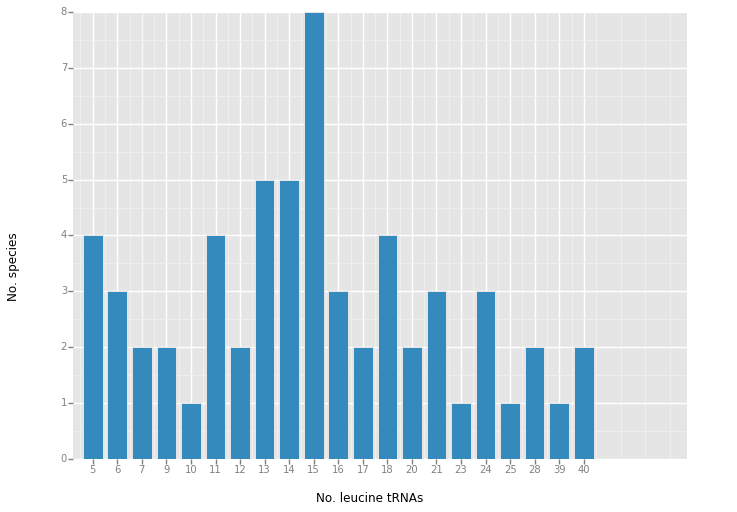

<ggplot: (-9223363266965900179)>

In [11]:
df = identities.ix[:, 'Organism'].value_counts()
df = df.to_frame().reset_index()
df.columns = ['Organism', 'Count']
ggplot(df, aes(x='Count')) + geom_bar() + xlab('No. leucine tRNAs') + ylab('No. species')

Most yeasts have 10-20 leucine tRNAs.

Next, we'll look at the distribution of anticodons.

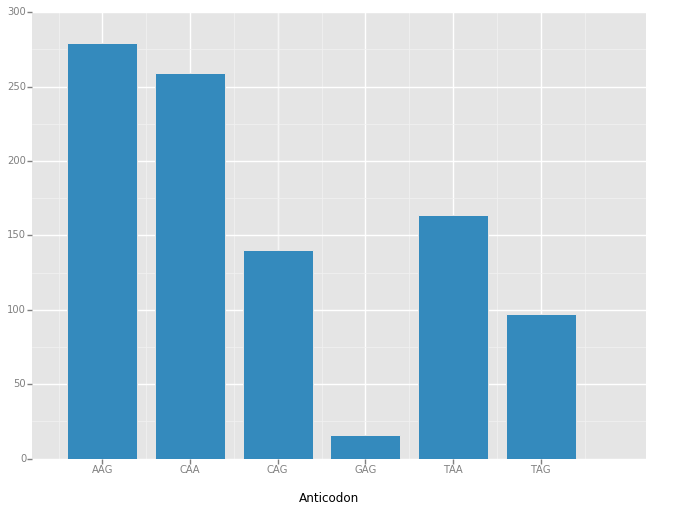

<ggplot: (-9223363266966423864)>

In [12]:
df = identities.ix[:, 'Anticodon'].to_frame()
ggplot(df, aes(x='Anticodon')) + geom_bar()

Now let's look at the percentage of fungi that contain the _S. cerevisiae_ identity elements. This is defined by whether an organism contains at least one leucine tRNA with the identity element.

In [265]:
a = pd.Series(range(10))
(a == a) & (a == a)

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

In [270]:
print('A35: {}\nG37: {}\nA73: {}\nA35+G37: {}\nA35+G37+A73: {}'.format(
        sum(any(trnas.A35 == "A") for organism, trnas in identities.groupby("Organism")),
        sum(any(trnas.G37 == "G") for organism, trnas in identities.groupby("Organism")),
        sum(any(trnas.A73 == "A") for organism, trnas in identities.groupby("Organism")),
        sum(any((trnas.A35 == "A") & (trnas.G37 == "G")) for organism, trnas in identities.groupby("Organism")),
        sum(any((trnas.A35 == "A") & (trnas.G37 == "G") & (trnas.A73 == "A")) for organism, trnas in identities.groupby("Organism"))))
        

A35: 60
G37: 60
A73: 60
A35+G37: 60
A35+G37+A73: 60


Looks like all species have one of each. Now let's look at the percentage of tRNAs by species that contain the _S. cerevisiae_ identity elements. 

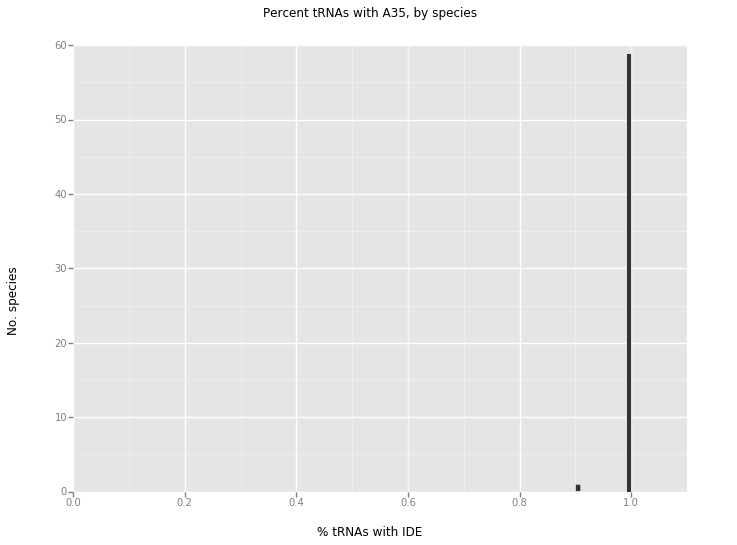

<ggplot: (-9223363266976960852)>

In [275]:
# Build a table with 1 row = 1 species, with (for each IDE) a fraction of the number of tRNAs with the IDE.
df = pd.concat(pd.DataFrame({'Organism': [organism], 
                             'A35': [sum(trnas.A35 == "A")/len(trnas.A35)],
                             'G37': [sum(trnas.G37 == "G")/len(trnas.G37)],
                             'A73': [sum(trnas.A73 == "A")/len(trnas.A73)]}) for organism, trnas in identities.groupby('Organism'))

df = pd.melt(df, id_vars = 'Organism', value_vars = ['A35', 'G37', 'A73'], var_name = 'IDE', value_name = '% tRNAs with IDE')
ggplot(df.ix[df.IDE == "A35"], aes(x = '% tRNAs with IDE')) + geom_histogram() + ylab('No. species') + xlim(0, 1.1) + ggtitle('Percent tRNAs with A35, by species')

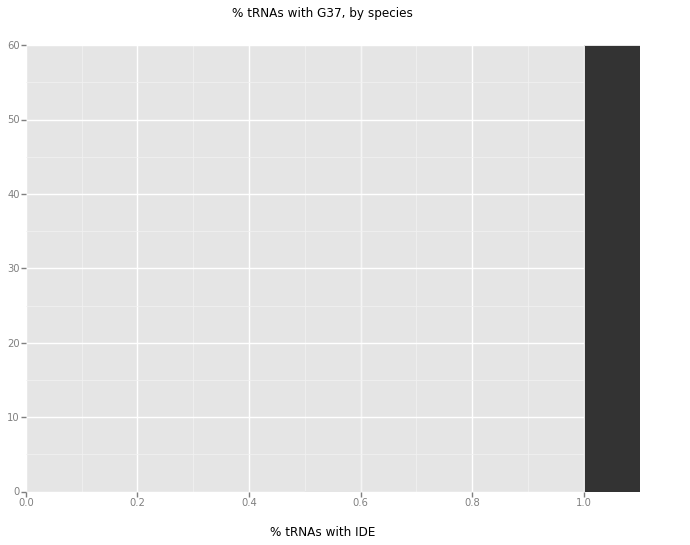

<ggplot: (8769877897350)>

In [278]:
ggplot(df.ix[df.IDE == "G37"], aes(x = '% tRNAs with IDE')) + geom_histogram() + xlim(0, 1.1) + ggtitle('% tRNAs with G37, by species')

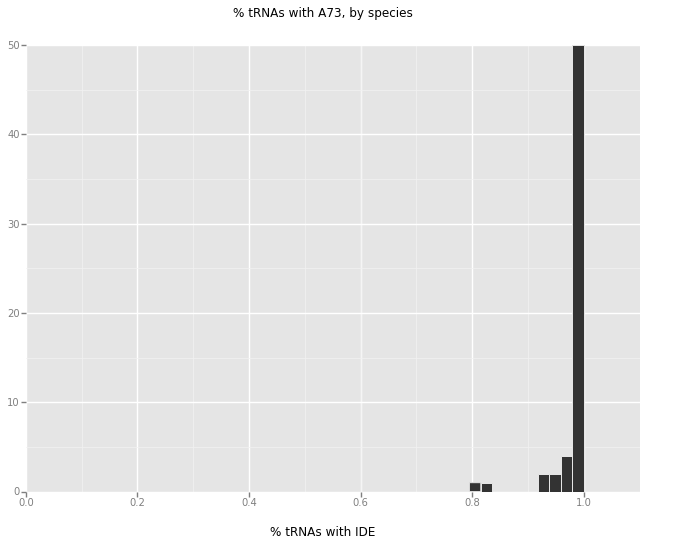

<ggplot: (8769877919559)>

In [277]:
ggplot(df.ix[df.IDE == "A73"], aes(x = '% tRNAs with IDE')) + geom_histogram() + xlim(0, 1.1) + ggtitle('% tRNAs with A73, by species')

So the vast majority of tRNAs have each of the identity elements. Is there a correlation between score and whether the identity elements are there? 

This wouldn't be too hard - give a score to all tRNAs based on whether the IDE is there, for a max score of 3. But this would be a circular comparison. The model scores are based on the identity elements to begin with, so it would only measure a correlation between the fungi-Leu specific IDEs and general tRNA signals. Which, I suppose, could be interesting, but it's the null hypothesis.

# References

1. Giegé, R., Sissler, M. & Florentz, C. Universal rules and idiosyncratic features in tRNA identity. Nucleic Acids Res. 26, 5017–35 (1998).